## VirtualEATING
###Andrew Lane, University of California, Berkeley

####Overview
CRISPR-EATING is a molecular biology protocol to generate libraries of CRISPR guide RNAs. The use of this this approach to generate a library suitable for chromosomal locus imaging requires ways to avoid regions that will be processed into non-specific guides, which (in part) is what these scripts are designed to achieve.

These scripts contain a set of functions that are assembled into a workflow to:
- Predict the sgRNA spacers produced when a particualr substrate DNA is subjected to the EATING protocol described in Lane et al., *Dev. Cell* (2015).
- Score those peredicted guides for specificity within a genome from which a BLAST database and an implementation of the CRISPR guide scoring algorithm described in Hsu et al (2013).
- Using the score information, pick out sub-regions within the substrate DNA that will produce clusters of high-specificity guides and design PCR primers to amplify only those regions.

Following the generation of suitable PCR primers from this tool, the "wet" portion of the protocol is as follows:
1. The output PCR primers (144 pairs in 144 separate reactions in the case of the labled 3MB region) are used to amplify from the substrate DNA. 
2. The resulting products are pooled and subjected to the EATING molecular biology protocol.
3. When complexed to dCas9-mNeonGreen (or other fluorescent protein), the resulting library can be used to image your desired locus.

####Prerequisites
1. Some experience with Python and the very basics of Biopython and BLAST
2. A Python installation with biopython, pickle
3. A BLAST database generated from the genome against which you would like to score your guides and a working BLAST installation. To generate the BLAST database, use a FASTA file containing your genome of interest. For example, [LAEVIS_7.1.repeatmasked.fa](ftp://ftp.xenbase.org/pub/Genomics/JGI/Xenla7.1/Xenla_7.1_JGI_scaffolds_on_Xenbase_GBrowse.tgz). Use the following syntax to generate the BLAST DB. (The -parse_seqids flag is critical; the guide scoring algorithm expects a database generated using this flag). 
        makeblastdb -in LAEVIS_7.1.repeatmasked.fa -dbtype nucl -parse_seqids -out xl71 -title ‘xl71’
This was tested using makeblastdb version 2.2.29+. Perform a test BLAST query on your database to check that your installation can find it.
4. The original FASTA file used to make the BLAST database must also be available; this is necessary so that it can be determined whether a guide BLAST database hit is adjacent to a PAM and therefore relevant for score determination. The entire genome is loaded entirely into memory in the current implementation and thus you need a computer with enough RAM (8-16GB) for this. (Future updates may remove this requirement)

####References: 
Hsu PD, Scott DA, Weinstein JA, Ran FA, Konermann S, Agarwala V, et al. DNA targeting specificity of RNA-guided Cas9 nucleases. Nat Biotechnol. Nature Publishing Group; 2013;31: 827–832. doi:10.1038/nbt.2647

###Using this notebook and adapting it for a particular purpose
The basic EATING-related logic is in the *eating* module (eating.py). This module contains functions (prefixed with "al_") to predict the guides that will be generated from an input DNA sequence and score the guides. 

##Import modules

In [1]:
import Bio 
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import Restriction 
from Bio.Restriction import *
from Bio.Alphabet.IUPAC import IUPACAmbiguousDNA
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import cPickle as pickle
import subprocess
import matplotlib
from eating import *
import multiprocessing as mp
from operator import itemgetter, attrgetter, methodcaller
import numpy

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Set up input files

###1. The FASTA file to be scored

In [2]:
path_to_genomic_data = "../../../MBP 750GB/andypy/Genomic Data/"
file_name = "LAEVIS_7.1.repeatMasked.fa"
genome = "xl71"

In [3]:
fasta_file = SeqIO.parse(str(path_to_genomic_data + file_name), "fasta")

###2. The genome against which generated guides are scored
See Prerequisites above for explanation.

In [4]:
xl71genome = SeqIO.parse(open(str(path_to_genomic_data + file_name), 'rb'), "fasta", alphabet=IUPACAmbiguousDNA())
xl71genomedict = {}
for item in xl71genome:
    xl71genomedict[item.id] = item

genomedict = xl71genomedict

In [5]:
len(xl71genomedict)

410604

##Begin custom processing

The FASTA file we've loaded (`fasta_file`) contains the entire *X. laevis* genome. The *X. laevis* genome hasn't yet been definitively assembled into physical chromosomes - instead, it's a large number of contigs or "scaffolds". For the purposes of making a library that labels a single region, we want to work with a big piece that we know is contiguous. So, we find the longest "scaffold".

In [6]:
longest = 0
for item in fasta_file:
    if len(item) > longest:
        longest = len(item)
        longscaffold = [item]

In [7]:
print(longscaffold[0].name + " is the longest scaffold at " "{:,}".format(len(longscaffold[0])) + " bp in length.")

Scaffold102974 is the longest scaffold at 21,560,636 bp in length.


Next, we want to digest this scaffold into guides. This uses the `al_diggesttarget` function contained in `eating.py` to produce a generator of scores.

In [8]:
cutslist = al_digesttarget(longscaffold)

In this version of the script, the output from `al_digesttarget` isn't especially readable, but for reference:

- Each item is a SeqRecord (see BioPython docs)
- The Sequence is the guide 20mer, written from 5' to 3'
- The ID is the cut-fragment of DNA of that an enzyme produces, counting from the left (i.e. the most 5' guide has an id of 1) and the strand that the guide is found on (F or R, where F is forward with respect to the input DNA), starting with all the HpaII cuts, then all the BfaI cuts, then all the ScrFI cuts. Note that the script predicts the results when each digestion is done in a separate tube, rather than when all enzymes are used as a mixture (which would kill some guides where cut sites of two different enzymes are <20 bp apart).
- The name is the sequence position of the left edge of the guide along the input DNA. For forward-direction guides, this is position of the 5' end of the guide. For reverse, it's position of the 3' end of the guide.
- The description is the enzyme that generates the guide's cut site.

![Guide Numbering](guide_numbering.png)
In this example (the most 5' 1500 bp of the chosen Scaffold), HpaII does not cut. Note that enzyme recognition sites are palindromic and thus recognizes a palindromic sequence containing a PAM on both strands. This results in a guide being generated on both sides of the cut site.

In [9]:
[item for item in al_digesttarget([longscaffold[0][0:1500]])]

[SeqRecord(seq=Seq('GCGCTGGCCAGAACGTTCTC', SingleLetterAlphabet()), id='1_F', name='788', description='BfaI', dbxrefs=['Scaffold102974']),
 SeqRecord(seq=Seq('AATGTCTTCTCCACGATTCC', SingleLetterAlphabet()), id='2_R', name='810', description='BfaI', dbxrefs=['Scaffold102974']),
 SeqRecord(seq=Seq('TAAAGGAGAAGGAAACCCCC', SingleLetterAlphabet()), id='2_F', name='1444', description='BfaI', dbxrefs=['Scaffold102974']),
 SeqRecord(seq=Seq('AGGGGAGGGATTTTTGTGCC', SingleLetterAlphabet()), id='3_R', name='1465', description='BfaI', dbxrefs=['Scaffold102974']),
 SeqRecord(seq=Seq('GGAGGGACAGCAGCTGGGCC', SingleLetterAlphabet()), id='4_F', name='734', description='ScrFI', dbxrefs=['Scaffold102974']),
 SeqRecord(seq=Seq('ATCTTTCTTGCCCCCCCCCC', SingleLetterAlphabet()), id='5_R', name='754', description='ScrFI', dbxrefs=['Scaffold102974'])]

Next, we'd like to take the 20mers extracted and score them against the entire *Xenopus laevis* genome. These lines score each guide variable region for specificity using the `xl71` BLAST database and the ` xl71genomedict dict` . This takes a couple of days of processing time on a four-core Intel Core i5 with 16 GB RAM, so instead we'll load a `pickle` of the resulting data object. (Later versions implement a MySQL database to store scores). Uncomment the below cells if you'd like to rebuild the BLAST score DB. 

The decompressed pickle is too big for GitHub, so unzip finalpicklescores_done.pkl.zip and place it outside of your sync'd directory.

In [10]:
#def multiscore_pool(x):
#    score = al_scoreguide(x, "xl71", xl71genomedict)
#    return score

In [11]:
#http://sebastianraschka.com/Articles/2014_multiprocessing_intro.html#An-introduction-to-parallel-programming-using-Python's-multiprocessing-module
#pool = mp.Pool(processes=2)
#results = [pool.apply(multiscore_pool, args=(x,)) for x in cutslist]
#pickle.dump(results, open( "finalpicklescores.pkl", "wb" ))
#pool.close()

In [12]:
results = pickle.load(open("../../finalpicklescores_done.pkl", "rb"))

The format of the resulting data is `(score, guide)`.

<module 'eating' from 'eating.py'>

In [179]:
reload(eating)
from eating import *

In [155]:
import sqlite3

In [138]:
genome = "xl71"

In [139]:
dbname = "xl71"

In [182]:
cur, con = db_connect("xl71")

Creating xl71.db.
Creating tables.


In [97]:
results_as_dict = []

In [98]:
for item in results:
    item[1].annotations["score"] = item[0]
    results_as_dict.append(item[1])

In [105]:
guide = results_as_dict[0]

In [107]:
data = []

In [116]:
        cur.execute("SELECT * FROM scores WHERE sequence = '{}' AND genome = '{}' AND version = '{}'".format(guide.seq, genome, version))
        data = cur.fetchall()


In [144]:
data

[{'genome': u'xl71',
  'id': 11,
  'score': 100.0,
  'sequence': u'GGGATTGGTGCACACGGAGC',
  'version': 0.0}]

In [ ]:
for index, item in enumerate(results_as_dict[0:11000]):
    eating.db_add_guide(cur, con, item, "xl71", 0)
    if str(index)[-3:] == "000":
        print index

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000

In [78]:
len(results_as_dict)

227520

In [81]:
item

SeqRecord(seq=Seq('TGCTGATAGGAGCTCCAGCC', SingleLetterAlphabet()), id='1210_R', name='1132966', description='HpaII', dbxrefs=['Scaffold102974'])

The scores in this object are an ordered list, with all HpaII scores first, then all BfaI scores and finally all ScrFI scores. We are interested in the distributioœn of scores along the DNA fragment, irrespective of the enzyme used to generate them. Thus, we want to rearrange the list with all scores from 5' to 3'. 

In [93]:
import copy
a = []
for (score, details) in results:
    a.append(int(details.name)) # The guide's name attribute contains its position in bp
resultssorted = zip(results, a)
resultssorted = sorted(resultssorted, key=itemgetter(1), reverse=False)
resultssorted = [item for item, null in resultssorted]

In [125]:
resultssorted[:5]

[(94,
  SeqRecord(seq=Seq('GGAGGGACAGCAGCTGGGCC', SingleLetterAlphabet()), id='66855_F', name='734', description='ScrFI', dbxrefs=['Scaffold102974'])),
 (64,
  SeqRecord(seq=Seq('ATCTTTCTTGCCCCCCCCCC', SingleLetterAlphabet()), id='66856_R', name='755', description='ScrFI', dbxrefs=['Scaffold102974'])),
 (66,
  SeqRecord(seq=Seq('GCGCTGGCCAGAACGTTCTC', SingleLetterAlphabet()), id='20037_F', name='788', description='BfaI', dbxrefs=['Scaffold102974'])),
 (64,
  SeqRecord(seq=Seq('AATGTCTTCTCCACGATTCC', SingleLetterAlphabet()), id='20038_R', name='810', description='BfaI', dbxrefs=['Scaffold102974'])),
 (2,
  SeqRecord(seq=Seq('TAAAGGAGAAGGAAACCCCC', SingleLetterAlphabet()), id='20038_F', name='1444', description='BfaI', dbxrefs=['Scaffold102974']))]

In [126]:
resultssorted[-5:]

[(100,
  SeqRecord(seq=Seq('GCACAATATGTTCAAATTGC', SingleLetterAlphabet()), id='66852_R', name='21559690', description='BfaI', dbxrefs=['Scaffold102974'])),
 (100,
  SeqRecord(seq=Seq('GAATTGCAATTTGCGATGTC', SingleLetterAlphabet()), id='66852_F', name='21559782', description='BfaI', dbxrefs=['Scaffold102974'])),
 (0,
  SeqRecord(seq=Seq('TTTGAAATCTGACATGGGGC', SingleLetterAlphabet()), id='66853_R', name='21559804', description='BfaI', dbxrefs=['Scaffold102974'])),
 (100,
  SeqRecord(seq=Seq('CTGTAACTGTCGCATGGATC', SingleLetterAlphabet()), id='66853_F', name='21560446', description='BfaI', dbxrefs=['Scaffold102974'])),
 (100,
  SeqRecord(seq=Seq('GATCCCATTCAGTTTATTTC', SingleLetterAlphabet()), id='66854_R', name='21560467', description='BfaI', dbxrefs=['Scaffold102974']))]

Let's extract the scores and plot their distribution on a histogram.

In [127]:
scores = [score for score, details in resultssorted]

In [128]:
def plot_score_histogram(scores):
    '''
    Input is a list of scores only (as ints)
    '''
    path = '/Library/Fonts/Microsoft/Arial.ttf'
    prop = matplotlib.font_manager.FontProperties(fname=path)
    matplotlib.rcParams['font.family'] = prop.get_name()
    bins = range(0,106,5)
    figure()
    hist(scores, bins, color="gray")
    tick_params(axis=u'both', labelsize=18)
    #savefig('Scaffold score distribution.pdf', format="pdf")

In [129]:
print(bins)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]


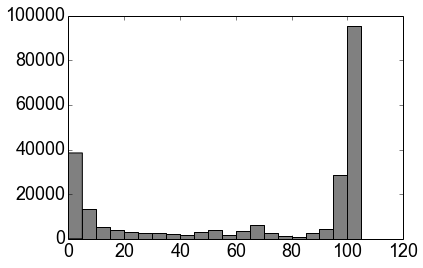

In [130]:
plot_score_histogram(scores)

So, there are ~5000 guides that are quite non-specific (score <= 4) and >14,000 guides that have a score of 100 and a further 4000 that score between 95 and 99.

####Finding clusters of high-scoring guides
To make a library of useful guides, we'd like to PCR through continuous clusters of the highest-scoring ones. Our oligonucleotide vendor [(IDT)](http://www.idtdna.com) has a minimum order of 288 oligos (3x 96-well plates) on a small and relatively inexpensive scale (5 pmol). To work within this limitation, we'd like to pick out 144 possible regions to PCR-amplify. 

If we are only willing to accept guides with a score of 100, we'd predict that our 144 PCR products will be short (there are probably few long spans of perfect-scoring guides). However, if we relax our requirement to >=99, we may get longer PCR products and thus more guides in our library. How does this scale at different cutoffs/thresholds?

In [215]:
def find_clusters_by_cutoff(resultssorted, x):
    starts=[]
    ends=[]
    previtemgood = 0
    for index, (score, details) in enumerate(resultssorted):
        if score >= x and previtemgood ==0 and len(details) >= 20: #this avoids guides that are shorter than 20 bp (from where an enzyme cuts twice in close proximity)
            starts.append((index, score, int(details.name)))
            previtemgood = 1
        elif score >= x and previtemgood == 1 and len(details) >=20:
            None
        elif previtemgood == 1:
            previtemgood =0
            ends.append((index-1, resultssorted[index-1][0], int(resultssorted[index-1][1].name)))
    run_positions = zip(starts, ends)
    goodruns_length = sorted([end - start for (start, i, j), (end,l,m) in run_positions], reverse=True)
    return (goodruns_length, run_positions)

In [216]:
threshold = range(0, 105, 5)
probeyield = []
for item in threshold:
    probeyield.append((item, sum(find_clusters_by_cutoff(resultssorted, item)[0][0:143])))

In [217]:
print(probeyield)

[(0, 22490), (5, 9307), (10, 8216), (15, 7902), (20, 7659), (25, 7348), (30, 7125), (35, 6831), (40, 6457), (45, 6323), (50, 5891), (55, 5035), (60, 4791), (65, 4237), (70, 3748), (75, 3577), (80, 3481), (85, 3432), (90, 3256), (95, 2894), (100, 1719)]


Populating the interactive namespace from numpy and matplotlib


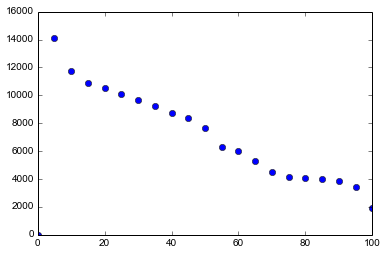

In [148]:
%pylab inline
figure()
plot([b for b, c in probeyield], [c for b, c in probeyield], "o")

Our "yield" of guides descends steadily from a cutoff of >=5 to a cutoff of >=95, then drops from 2894 guides produced at a cutoff of 95 to 1719 at 100. So, a cutoff of >=95 might be a good balance between specificity and yield.

In [205]:
threshold = 95
runs = find_clusters_by_cutoff(resultssorted, threshold)[1]
#(countofguides, (startguidenumberfrom5', startscore, startpositionbp), (endguidenumberfrom5', endscore, endpositionbp))
goodruns = sorted([((i_end - i), (i, s, pos), (i_end, s_end, pos_end)) for (i, s, pos), (i_end, s_end, pos_end) in runs], reverse=True)

We next asked what happens if we concentrate the guides into a smaller region. Does the guide yield scale with the region selected? To test this, we cut the input DNA into sections of 1/7 the ~21MB starting length

In [247]:
probeyield = []
x = 95
fraction = 7.0
overlap = 2.0
region_to_extract = len(resultssorted)/fraction

for i in [float(item)/overlap for item in range(int(overlap*fraction+2.0))]:
    goodruns = find_clusters_by_cutoff(resultssorted[int(region_to_extract*i):int(region_to_extract*(i+1))], x)[0]
    probeyield.append((i, int(region_to_extract*i), sum(goodruns[0:143])))
    if sum(goodruns[0:143]) == 0:
        break

In [248]:
probeyield

[(0.0, 0, 1948),
 (0.5, 16251, 1977),
 (1.0, 32502, 2070),
 (1.5, 48754, 1939),
 (2.0, 65005, 1781),
 (2.5, 81257, 1948),
 (3.0, 97508, 1980),
 (3.5, 113760, 1836),
 (4.0, 130011, 1966),
 (4.5, 146262, 2004),
 (5.0, 162514, 1985),
 (5.5, 178765, 1980),
 (6.0, 195017, 2113),
 (6.5, 211268, 1923),
 (7.0, 227520, 0.0)]

Looks like the final 1/7 of the scaffold has the densest guide yield.

In [ ]:
#Modify resultssorted to only include the 3.4MB region used. (18121076 to (21505465+786) = 21506251)
resultssorted = [item for item in resultssorted if int(item[1].name) >= 18121076 and int(item[1].name) <= 21506251]
scores = [score for score, details in resultssorted]

In [25]:
probeyield

[(0.0, 0, 95, 1958),
 (0.5, 16251, 95, 1987),
 (1.0, 32502, 95, 2081),
 (1.5, 48753, 95, 1949),
 (2.0, 65004, 95, 1792),
 (2.5, 81255, 95, 1958),
 (3.0, 97506, 95, 1990),
 (3.5, 113757, 95, 1846),
 (4.0, 130008, 95, 1976),
 (4.5, 146259, 95, 2015),
 (5.0, 162510, 95, 1996),
 (5.5, 178761, 95, 1992),
 (6.0, 195012, 95, 2124),
 (6.5, 211263, 95, 1934),
 (7.0, 227514, 95, 2),
 (7.5, 243765, 95, 0)]

OK, list is set up to contain:
    - Positions of 5' and 3' adjacent guides
    - Number of guides in amplicons
    - Actual guide details

Write out XML file of these amplicons:

Try and alter to better figure out the edge cases of good and bad guides being close to each other and making it hard to prime:

In [28]:
probeyield = []
x =95
one_mb = len(resultssorted)/7
i = 6.0
amplicon_positions = []

scores = [(score, len(details)) for score, details in resultssorted[int(one_mb*i):int(one_mb*(i+1))]]
scores_and_details = resultssorted[int(one_mb*i):int(one_mb*(i+1))]
runs=[]
ends=[]
previtemgood = 0
for index, (item, guide_length) in enumerate(scores):
    if item >= x and previtemgood ==0 and guide_length > 19:
        runs.append(index)
        previtemgood = 1
    elif item >= x and previtemgood == 1 and guide_length > 19:
        None
    elif previtemgood == 1:
        previtemgood =0
        ends.append(index)
runs = zip(runs, ends)
for i in runs:
    start, end = i
    try:
        fiveprimeabuttingguide = scores_and_details[start-1][1]
        threeprimeabuttingguide = scores_and_details[end][1]
    except: 
        fiveprimeabuttingguide = "0"
        threeprimeabuttingguide = "None"
        print "error"
    if end - start > 3:
        amplicon_positions.append(((fiveprimeabuttingguide, threeprimeabuttingguide), end-start, scores_and_details[start:end]))

#goodruns = sorted([length for length, guide_list in amplicon_positions], reverse=True)
goodruns = sorted(amplicon_positions, reverse=True, key=itemgetter(1))# sorts by the number of guides in list

#probeyield.append((i, int(one_mb*i), x, sum([j for i, j, k in goodruns[0:144]])))

In [29]:
len(goodruns)

257

First, go through the left edge of each amplicon to figure out priming rules depending on what's next to stuff.

In [30]:
for index, item in enumerate(goodruns[49:170]):
    print(str(index))
    print("Before: \t" + item[0][0].id + " " + item[0][0].name) #could take all of this
    print("First good:\t" + item[2][0][1].id + " " + item[2][0][1].name)
    distancebetweenlastbadandfirstgood = int(item[2][0][1].name) - int(item[0][0].name)
    if "F" in item[0][0].id and "R" in item[2][0][1].id:
        print("||||||||||||||||||||||OK, handleable; prime ~10 after start of prior bad. But include another ~18 of first good in primeable region.")
    elif "R" in item[0][0].id and "R" in item[2][0][1].id and distancebetweenlastbadandfirstgood <=20:
        print("||||||||||||||||||||||Hard. Prime at window 1nt after start of last bad start, and all the way into 15nt after first good start (to encompass restriction site).")
    elif "R" in item[0][0].id and "F" in item[2][0][1].id and distancebetweenlastbadandfirstgood:
        print("||||||||||||||||||||||Prime at window 1nt after start of last bad start, and all the way into 18nt after first good start.")
    elif "F" in item[0][0].id and "F" in item[2][0][1].id and distancebetweenlastbadandfirstgood < 10:
        print("||||||||||||||||||||||Impossible. Exclude; too close together and in same direction")
    else:
        print("3333333333333333333333333333333333")
    print(str(distancebetweenlastbadandfirstgood) + "\n")

0
Before: 	113387_R 21352790
First good:	113387_F 21353141
||||||||||||||||||||||Prime at window 1nt after start of last bad start, and all the way into 18nt after first good start.
351

1
Before: 	113632_R 21468108
First good:	113632_F 21468214
||||||||||||||||||||||Prime at window 1nt after start of last bad start, and all the way into 18nt after first good start.
106

2
Before: 	66748_F 21498447
First good:	66749_R 21498469
||||||||||||||||||||||OK, handleable; prime ~10 after start of prior bad. But include another ~18 of first good in primeable region.
22

3
Before: 	65851_F 21040211
First good:	65852_R 21040233
||||||||||||||||||||||OK, handleable; prime ~10 after start of prior bad. But include another ~18 of first good in primeable region.
22

4
Before: 	19682_F 21062707
First good:	19683_R 21062729
||||||||||||||||||||||OK, handleable; prime ~10 after start of prior bad. But include another ~18 of first good in primeable region.
22

5
Before: 	65945_F 21084932
First good:	6594

In [29]:
item

((SeqRecord(seq=Seq('TTTAATTCTCAGTCCGGACC', SingleLetterAlphabet()), id='110620_F', name='19959202', description='ScrFI', dbxrefs=['Scaffold102974']),
  SeqRecord(seq=Seq('CGGC', SingleLetterAlphabet()), id='18786_F', name='19959830', description='HpaII', dbxrefs=['Scaffold102974'])),
 12,
 [(100,
   SeqRecord(seq=Seq('TTGTGGCGGGGTTCCAGGTC', SingleLetterAlphabet()), id='18784_R', name='19959218', description='HpaII', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('TCCATTTGTGGCGGGGTTCC', SingleLetterAlphabet()), id='110621_R', name='19959223', description='ScrFI', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('AATGGGGTCTGAGGTTTGAC', SingleLetterAlphabet()), id='18784_F', name='19959374', description='HpaII', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('ATGGGGTCTGAGGTTTGACC', SingleLetterAlphabet()), id='110621_F', name='19959375', description='ScrFI', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('GTAATTTGGGACATGAGCCC', SingleLetterAl

Next, go through various scenarios for the right edge: (constraints on priming regions given different configurations of last good and first bad guides)

In [30]:
'''
for index, item in enumerate(goodruns[50:200]):
    print(str(index))
    print("Last good:\t" + item[2][-1][1].id + " " + item[2][-1][1].name)
    print("After:  \t" + item[0][1].id + " " + item[0][1].name) # 
    distancebetweenlastgoodandfirstbad = int(int(item[0][1].name) - int(item[2][-1][1].name))
    if "F" in item[2][-1][1].id and "R" in item[0][1].id:
        print("||||||||||||||||||||||Prime left 10 after start of next bad to ~15 after last good.")
    elif "R" in item[2][-1][1].id and "F" in item[0][1].id:
        print("||||||||||||||||||||||Prime anywhere right of ~2nt after last good to ~19nt after start of first bad")
    elif "R" in item[2][-1][1].id and "R" in item[0][1].id and distancebetweenlastgoodandfirstbad < 20:
        print("||||||||||||||||||||||Prime anywhere right of ~2nt after last good to ~10nt after start of first bad")
    elif "F" in item[2][-1][1].id and "F" in item[0][1].id and distancebetweenlastgoodandfirstbad < 20:
        print("||||||||||||||||||||||Prime anywhere right of ~2nt after last good to ~19nt after start of first bad")
    else:
        print("3333333333333333333333333333333333")
    print(str(distancebetweenlastgoodandfirstbad) + "\n")
'''

'\nfor index, item in enumerate(goodruns[50:200]):\n    print(str(index))\n    print("Last good:\t" + item[2][-1][1].id + " " + item[2][-1][1].name)\n    print("After:  \t" + item[0][1].id + " " + item[0][1].name) # \n    distancebetweenlastgoodandfirstbad = int(int(item[0][1].name) - int(item[2][-1][1].name))\n    if "F" in item[2][-1][1].id and "R" in item[0][1].id:\n        print("||||||||||||||||||||||Prime left 10 after start of next bad to ~15 after last good.")\n    elif "R" in item[2][-1][1].id and "F" in item[0][1].id:\n        print("||||||||||||||||||||||Prime anywhere right of ~2nt after last good to ~19nt after start of first bad")\n    elif "R" in item[2][-1][1].id and "R" in item[0][1].id and distancebetweenlastgoodandfirstbad < 20:\n        print("||||||||||||||||||||||Prime anywhere right of ~2nt after last good to ~10nt after start of first bad")\n    elif "F" in item[2][-1][1].id and "F" in item[0][1].id and distancebetweenlastgoodandfirstbad < 20:\n        print("||

Summarize priming rules:
Left edge:
Bad   Good     Permissible priming distance: permissible_start (from start of prior bad) to required_start (from start of first good)
F     R        10, 14
R     R        1, 14
R     F        1, 18
F     F        10, 18

Right edge:
Good  Bad  Permissible priming distance: required_end (after start of last good) to permissible_end (after start of next bad)
R     F    2,19
F     R    8,10
R     R    2,10
F     F    8,19

In [31]:
# Set up the input for primer3:
# Sequence available to PCR:
guide_count = []
amps_in_3MB = []

for index, item in enumerate(goodruns[0:400]):
    left_outside = item[0][0].id[-1]
    left_inside = item[2][0][1].id[-1]
    if left_outside == "F" and left_inside == "R":
        permissible_start = int(item[0][0].name) + 10
        required_start_absolute = int(item[2][0][1].name) +14
    elif left_outside == "R" and left_inside == "R":
        permissible_start = int(item[0][0].name) + 1
        required_start_absolute = int(item[2][0][1].name) +14
    elif left_outside == "R" and left_inside == "F":
        permissible_start = int(item[0][0].name) + 1
        required_start_absolute = int(item[2][0][1].name) +18
    elif left_outside == "F" and left_inside == "F":
        permissible_start = int(item[0][0].name) + 10
        required_start_absolute = int(item[2][0][1].name) +18
    else:
        print("error on left")
    
    right_inside = item[2][-1][1].id[-1]
    right_outside = item[0][1].id[-1]
    if right_outside == "F" and right_inside == "R":
        permissible_end = int(item[0][1].name) + 19 
        required_end_absolute = int(item[2][-1][1].name) + 2
    elif right_outside == "R" and right_inside == "F":
        permissible_end = int(item[0][1].name) + 10
        required_end_absolute = int(item[2][-1][1].name) + 8 
    elif right_outside == "R" and right_inside == "R":
        permissible_end = int(item[0][1].name) + 10
        required_end_absolute = int(item[2][-1][1].name) + 2
    elif right_outside == "F" and right_inside == "F":
        permissible_end = int(item[0][1].name) + 19
        required_end_absolute = int(item[2][-1][1].name) + 8
    else:
        print("error on right")

    amp = longscaffold[0][permissible_start:permissible_end]
    # Bounds that need to be included in PCR product :
    required_start_relative = required_start_absolute-permissible_start
    required_end_relative = required_end_absolute - permissible_start
    amp.dbxrefs=((required_start_relative, required_end_relative))
# Set up some other stuff:
    amp.name =str(item[0][0].name)
    amp.id =str(item[0][0].name)
    amp.description=str(item[1])
    amp.seq.alphabet = IUPACAmbiguousDNA()
    if "NNNNN" in amp.seq: # Exclude if it has runs of Ns
        None
        #print amp.name + " contains ns " + str(item[1])
    else:
        amps_in_3MB.append(amp)
        guide_count.append(item[1])
amps_in_3MB_gen = (i for i in amps_in_3MB)

print sum(guide_count[0:144])

1281


In [32]:
def al_primersearch(current_amp):
    '''
    Returns a dict of primer parameters. 
    '''
    length_of_required_region = current_amp.dbxrefs[1]-current_amp.dbxrefs[0]
    start_of_required_region = current_amp.dbxrefs[0]
    end_of_required_region = current_amp.dbxrefs[1]
    primeableregionleft_start = str(0)
    primeableregionleft_length = str(start_of_required_region)
    primeableregionright_start = str(end_of_required_region)
    primeableregionright_length = str(len(current_amp)-end_of_required_region)
    boulder = open("current_amp.boulder", "w")
    boulder.write("SEQUENCE_ID=" + current_amp.id + "\n")
    boulder.write("SEQUENCE_TEMPLATE=" + str(current_amp.seq) + "\n")
    #boulder.write("SEQUENCE_INCLUDED_REGION=" + "0," + str(len(current_amp.seq)) + "\n")
    #boulder.write("SEQUENCE_TARGET=" + str(current_amp.dbxrefs[0]) + "," + str(current_amp.dbxrefs[1] - current_amp.dbxrefs[0]) + "\n")
    boulder.write("SEQUENCE_PRIMER_PAIR_OK_REGION_LIST=" + primeableregionleft_start + "," + primeableregionleft_length+","\
                  +primeableregionright_start+"," + primeableregionright_length + "\n")
    boulder.write("PRIMER_PRODUCT_SIZE_RANGE=" +str(length_of_required_region) + "-"  + str(len(current_amp)) + "\n")
    boulder.write("PRIMER_PRODUCT_OPT_SIZE=" + str(length_of_required_region) + "\n")
    #boulder.write("P3_FILE_FLAG=1\n")
    boulder.write("=\n")
    boulder.close()
    primer_output = subprocess.check_output(["primer3_core", "current_amp.boulder",\
                              "-p3_settings_file=primer3_global_parameters.txt"])
    primerdict = {}
    for item in primer_output.split("\n")[0:-3]:
        val = item.split("=")[1]
        try:
            val = float(val)
        except: pass
        primerdict[item.split("=")[0]]=val
    return primerdict

In [33]:
def al_screen_primer(primer):
    '''
    Input is a primer as a string.
    '''
    currfile = open("currprimer.fa", "w")
    currfile.write(">" + str(primer) + "\n")
    currfile.write(str(primer))
    currfile.close()
    blastn_cline = NcbiblastnCommandline(query="currprimer.fa", db="xl71", \
    task = "blastn-short",outfmt=5, out="primerblast.tmp", max_target_seqs=100, num_threads = 8)
    blastn_cline
    result = blastn_cline()
    badprimer = 0
    # Parse data
    result_handle = open("primerblast.tmp")
    blast_record = NCBIXML.read(result_handle) # if there were multiple queries, use NCBIXML.parse(result_handle)
    # How many matches are there with more than 14 or matching bases?
    match14 = 0
    for x in blast_record.alignments:
        for y in x.hsps:
            if y.positives > 14:
                match14 = match14 + 1
    match15 = 0
    for x in blast_record.alignments:
        for y in x.hsps:
            if y.positives > 15:
                match15 = match15 + 1
    #print(primer.description)
    #print(match14)   
    #print(match15)
    # Set a cutoff of 
    if match14 > 40:
        badprimer = 1
    elif match15 > 10:
            badprimer = 1
    return badprimer

In [34]:
def al_collect_good_primers(template, primerdict):
    i = 0
    badlist = []
    try:
        while i < primerdict["PRIMER_PAIR_NUM_RETURNED"]:
            bad = 0
            leftprimer = primerdict[str("PRIMER_LEFT_" + str(i) + "_SEQUENCE")]
            leftprimer_start =  str(primerdict[str("PRIMER_LEFT_"+ str(i))].split(",")[0])
            leftprimer_length =  str(primerdict[str("PRIMER_LEFT_"+ str(i))].split(",")[1])
            leftprimer_gc =  str(primerdict[str("PRIMER_LEFT_"+ str(i) + "_GC_PERCENT")])
            leftprimer_tm =  str(primerdict[str("PRIMER_LEFT_"+ str(i) + "_TM")])

            rightprimer = primerdict[str("PRIMER_RIGHT_" + str(i) + "_SEQUENCE")]
            rightprimer_start =  str(primerdict[str("PRIMER_RIGHT_"+ str(i))].split(",")[0])
            rightprimer_length =  str(primerdict[str("PRIMER_RIGHT_"+ str(i))].split(",")[1])
            rightprimer_gc =  str(primerdict[str("PRIMER_RIGHT_"+ str(i) + "_GC_PERCENT")])
            rightprimer_tm =  str(primerdict[str("PRIMER_RIGHT_"+ str(i) + "_TM")])

            product_len = int(rightprimer_start) + int(rightprimer_length) - int(leftprimer_start)
            left_bad = al_screen_primer(leftprimer)
            right_bad = al_screen_primer(rightprimer)
            #print bad
            if left_bad == 0 and right_bad == 0:
                with open("primerlist.txt", "a") as primerlist:
                    primerlist.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % \
                         (template.name,leftprimer,leftprimer_start,leftprimer_length,leftprimer_tm,leftprimer_gc,\
                         rightprimer,rightprimer_start,rightprimer_length,rightprimer_tm,rightprimer_gc,\
                         len(template.seq),str(product_len),template.description))
                    primerlist.close()
                print("Success!")
                break
            if left_bad ==1:
                print("iteration" + str(i) + "left primer" + leftprimer + "is bad")
            if right_bad == 1:    
                print("iteration" + str(i) + "right primer" + rightprimer + "is bad")
            i = i +1
            if left_bad ==1 and right_bad ==1 and i ==primerdict["PRIMER_PAIR_NUM_RETURNED"]:
                with open("primerlist.txt", "a") as primerlist:
                    primerlist.write("All the primers were bad for this amplicon!\n")
                    primerlist.close()
    except:
        with open("primerlist.txt", "a") as primerlist:
            primerlist.write("Primer3 failed to find any primers for this amplicon! " + primerdict["SEQUENCE_PRIMER_PAIR_OK_REGION_LIST"] + "\n")
            primerlist.close()
        print("Primer3 failed to find any primers for this amplicon! " + primerdict["SEQUENCE_PRIMER_PAIR_OK_REGION_LIST"] + "\n")
        print sys.exc_info()

In [35]:
amps_in_3MB[0]

SeqRecord(seq=Seq('ttccaagcattctggataacaggtcccatacctgtaattatCTTTTTGATGTAC...GGC', IUPACAmbiguousDNA()), id='21447709', name='21447709', description='32', dbxrefs=(799, 3638))

In [36]:
#with open("primerlist.txt", "w") as primerlist:
    #primerlist.write("Sequence_id\tforward_seq\tforward_start\tforward_length\tforward_tm\tforward_gc\treverse_seq\treverse_start\treverse_length\treverse_tm\treverse_gc\tinput_seq_length\tPCR_product_length\tGuides_Contained\n")
    #primerlist.close()

for item in amps_in_3MB:
    current_amp = item
    primerdict = al_primersearch(current_amp)
    al_collect_good_primers(item, primerdict)

Primer3 failed to find any primers for this amplicon! 0,799,3638,275

(<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x266ce8cf8>)
Primer3 failed to find any primers for this amplicon! 0,1059,4068,5

(<type 'exceptions.KeyError'>, KeyError('PRIMER_PAIR_NUM_RETURNED',), <traceback object at 0x266cde7a0>)
iteration0right primerACAAGTCCCAGAATCCCAAGis bad
Success!
Primer3 failed to find any primers for this amplicon! 0,25,2606,9

(<type 'exceptions.KeyError'>, KeyError('PRIMER_PAIR_NUM_RETURNED',), <traceback object at 0x266d06488>)
Success!
iteration0left primerGAAACAGATGCAGAGAGAGGis bad
Success!
iteration0right primerCTAACTGCTGACAGCACTGTis bad
Success!
iteration0right primerAATCTGCCCCTAGAAGTCCis bad
iteration0left primerGGCTAGACAGACAGGATTGAis bad
Success!
iteration0right primerTGAAAAGCTTCTAGGACTATis bad


KeyboardInterrupt: 

In [37]:
goodruns_dict = {}
for item in goodruns:
    goodruns_dict[int(item[0][0].name)] = item

In [38]:
print(longscaffold[0][19991274:19991274+3230].seq)

GGACCCCTTGCTCGGGTTCCGGTACCAGTGTGTATAGTAACCCAAGGAAGGTTAAGGCAGACCCTGACCCATCCACCTGTTATACTTATAAATATATAATACACAAAAGCCATGAATATCCTGTAAATTATATCCTTATAAACGGTGAGTAGTGATGTCATCAGTTATAAACGGTGAGTAGTGATGTCATTTCTGTCACATGACTTACTAAAATTTGtgtattataataaataaagtacccccagttgtaaaatatgaggatattagaagttacctcggagttccatgacctgtatataaacacTCGGCCTTCGGCCTCATGTTTTATATGGTCATGAAACAGACAATTAAAAACAGCTGCTAATTCATAATATACAAACCAATTTTCTTCTTTTCTACATTTCTGACAGATATTTGATATCTCCTGGGATCCATTTCAGTCAAACAGACTGGTTAGCTGTGGAGTTAAGCACATAAAGGTGCGTTTTTTTCTGTTAAAAACAATTTTAGTATTACCAATTAAACCTGTCCCGGTTTTAATAACTTTATATTCCTCATTGCAGTTACAGAAAGGAAATCTAAATCTACATTAAACGAGTTAAGCCACGTTCCTTAGTATAAATTCTCTTAAGCTTTTGGGGCTGTGATTCTTGCTGGTAGTGATTTGGGAGTTGCTGGTAGAACCTCATACATTTATTACTACACTAAAAACTTGGGAGGCCTTTGTGCCCTCCAAATGTGGCACTGCTGCTCCTGGTATGGTTGAGATATAACAGCAGCTGGAAGACACAATAGCCAGCCCTGGTTTTCTGAAGCAGAACCTTCCAGTGATGAACATGGTTAGCAGATATTTTTCCAATATCCATACTATCATATCTGCTCTTTTTGGCAAAAAAAATCCAAGTTTCCTAACAGAGCAGTTCACATTCATGTCCTTCCTATCATATTTACTCTATATCACTTCTCAATATCCAATCCAGGAAGAACTTACCTGTGAGAG

In [39]:
goodruns_dict[19991274]

((SeqRecord(seq=Seq('TGGACCCCTTGCTCGGGTTC', SingleLetterAlphabet()), id='18823_F', name='19991274', description='HpaII', dbxrefs=['Scaffold102974']),
  SeqRecord(seq=Seq('GTCATTATAATATTGGCACC', SingleLetterAlphabet()), id='110693_R', name='19994491', description='ScrFI', dbxrefs=['Scaffold102974'])),
 23,
 [(99,
   SeqRecord(seq=Seq('GTTACTATACACACTGGTAC', SingleLetterAlphabet()), id='18824_R', name='19991296', description='HpaII', dbxrefs=['Scaffold102974'])),
  (95,
   SeqRecord(seq=Seq('GACAGATATTTGATATCTCC', SingleLetterAlphabet()), id='110685_F', name='19991680', description='ScrFI', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('GTTTGACTGAAATGGATCCC', SingleLetterAlphabet()), id='110686_R', name='19991701', description='ScrFI', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('ATTACCAATTAAACCTGTCC', SingleLetterAlphabet()), id='18824_F', name='19991786', description='HpaII', dbxrefs=['Scaffold102974'])),
  (100,
   SeqRecord(seq=Seq('ATTACCAATTAAACCTGTCC', 

Next up: look at the guides generated from the selected amplicons and rank non-target scaffolds for recognition.

In [40]:
amps_in_3MB[:2]

[SeqRecord(seq=Seq('ttccaagcattctggataacaggtcccatacctgtaattatCTTTTTGATGTAC...GGC', IUPACAmbiguousDNA()), id='21447709', name='21447709', description='32', dbxrefs=(799, 3638)),
 SeqRecord(seq=Seq('GTCCAACGATCGGATCCTTCACGTTCGCAAACGGGCGGTCGGATCGCGGGACCG...CCG', IUPACAmbiguousDNA()), id='20177951', name='20177951', description='26', dbxrefs=(1059, 4068))]

In [41]:
for item in amps_in_3MB:
    item.id = str(item.id)

In [42]:
len(amps_in_3MB)

356

In [43]:
from random import random

In [37]:
pooled_PCR_guides = al_digesttarget(amps_in_3MB)
pooled_PCR_guides = [item for item in pooled_PCR_guides]

In [159]:
SeqIO.write(pooled_PCR_guides, "pooled_PCR_guides.fasta", "fasta")

4732

In [45]:
print len(pooled_PCR_guides)

4732


In [32]:
#Now that we have the individual guides in the amps used, pick out which real PCR products we made:
## Make a list of amplicon starts and lengths:
import pandas as pd

In [33]:
pcr_starts = pd.read_table("used_pcrs.csv", header = None)
pcr_starts.columns = ["amplicon", "start", "length"]

In [44]:
pcr_starts

,amplicon,start,length
0,19100468,1011,4088
1,21447709,137,3594
2,19991274,4,3230
3,18505915,28,2905
4,18663621,193,2660
5,21065410,302,2638
6,18909500,172,2612
7,19947076,109,2600
8,21221279,107,2450
9,20078715,40,2444


In [34]:
bounds = []

for row in [item for item in pcr_starts.itertuples()]:
    bounds.append((row[0]+1, row[1] + row[2], row[1]+row[2]+row[3]))

In [43]:
bounds

[(1, 19101479, 19105567),
 (2, 21447846, 21451440),
 (3, 19991278, 19994508),
 (4, 18505943, 18508848),
 (5, 18663814, 18666474),
 (6, 21065712, 21068350),
 (7, 18909672, 18912284),
 (8, 19947185, 19949785),
 (9, 21221386, 21223836),
 (10, 20078755, 20081199),
 (11, 18963822, 18966264),
 (12, 20598378, 20600777),
 (13, 20331342, 20333678),
 (14, 20470453, 20472787),
 (15, 21297513, 21299811),
 (16, 21206409, 21208552),
 (17, 18974440, 18976545),
 (18, 19807569, 19809638),
 (19, 19667909, 19669949),
 (20, 20052429, 20054421),
 (21, 19375398, 19377350),
 (22, 19045152, 19047099),
 (23, 18502237, 18504171),
 (24, 21417931, 21419817),
 (25, 19717879, 19719717),
 (26, 18926848, 18928673),
 (27, 20915230, 20917048),
 (28, 21307208, 21309022),
 (29, 18622489, 18624302),
 (30, 20251486, 20253258),
 (31, 20306932, 20308691),
 (32, 20490932, 20492688),
 (33, 18586568, 18588320),
 (34, 20368447, 20370178),
 (35, 19343533, 19345258),
 (36, 20033970, 20035638),
 (37, 20049275, 20050941),
 (38, 1986

In [45]:
pickle.dump(bounds, open("boundaries of 144 pcrs used in 3mb region within scaffold102974.pkl", "wb"))

In [35]:
print min([item[1] for item in bounds])
max([item[2] for item in bounds])

18121082


21506254

In [38]:
guides_used = []
for item in pooled_PCR_guides:
    for boundary in bounds:
        scaffold_position = int(item.name) + int(item.dbxrefs[0])
        if scaffold_position >= boundary[1] and scaffold_position <= boundary[2]:
            guides_used.append(item)

In [39]:
len(guides_used)

260

In [110]:
%run "../Sequence Analysis/al_funcs.ipynb"

In [111]:
allscores = []
for guide in guides_used:
    oneguide = al_scoreguide_density(guide, "xl71", xl71genomedict)
    allscores.append(oneguide)

In [136]:
for item allscores[2][2][1][1][1]

u'Scaffold102974'

In [158]:
for item in allscores[0:10000]:
    for subitem in item:
        try:
            if subitem[2][1][1] == 'Scaffold27036':
                print(subitem[2][1])
        except: None

((0, 0, 0), u'Scaffold27036', 5877054, u'GGGAAGATATCCTTCC')
((0, 0, 0), u'Scaffold27036', 3472975, u'CTGAATTAAGGACTGA')
((0, 0, 0), u'Scaffold27036', 6934353, u'ATTAACTTGCCCATTTCC')
((0, 0, 0), u'Scaffold27036', 8092325, u'TGTACAAACGATGACT')
((0, 0, 0), u'Scaffold27036', 6466128, u'TCATTGGTTCTTCATGA')
((0, 0, 0), u'Scaffold27036', 5333017, u'GGGGGCATCCTTTACTGGCC')
((0.025745579999999994, 0.20879120879120883, 0.1111111111111111), u'Scaffold27036', 5744261, u'TCTTTGTATATTGGTTT')
((0.986, 0.20879120879120883, 0.1111111111111111), u'Scaffold27036', 5512553, u'AGCCAATAGGAAAGGAC')
((0, 0, 0), u'Scaffold27036', 2408054, u'GTATCATATTGATT')
((0.009912048299999998, 0.20879120879120883, 0.0625), u'Scaffold27036', 7839221, u'TTGGGTTTGCCTCAAA')
((0.131355, 0.20879120879120883, 0.25), u'Scaffold27036', 6768011, u'AGGAGATCCATCAGTTCA')
((0, 0, 0), u'Scaffold27036', 6963650, u'CACCAGGTTGGTAACAT')


In [153]:
subitem[2][1][1]

u'Scaffold79772'

In [113]:
scaffold_hit_dict = {}
scaffold_hit_dict_t1 = {}
for item in allscores:
    for hit in item[2]:
        #print hit
        try:
            scaffold_hit_dict[hit[1][1]] = scaffold_hit_dict[hit[1][1]] + hit[0]
            scaffold_hit_dict_t1[hit[1][1]] = scaffold_hit_dict_t1[hit[1][1]] + hit[1][0]
        except: 
            scaffold_hit_dict[hit[1][1]] = hit[0]
            scaffold_hit_dict_t1[hit[1][1]] = hit[1][0]


In [118]:
sorted_scores = sorted(scaffold_hit_dict.items(), key=itemgetter(1), reverse=True)
len(sorted_scores)

7667

In [126]:
sorted_scores[1]

(u'Scaffold58878', 215.3465109631277)

In [ ]:
sorted_scores_t1 = sorted(scaffold_hit_dict_t1.items(), key=lambda (k,v): operator.itemgetter(1)(k), reverse=True)
sorted_scores_t1

In [271]:
#pickle.dump(sorted_scores, open("used_guides_scores.pkl", "wb" ))

In [300]:
out = xl71genomedict['Scaffold58878']

In [301]:
out.id = "0"

In [302]:
out

SeqRecord(seq=Seq('GGACTTATTAACACTGGCTGAATCTGTGCAGGTCATTAGTCTGTATGTGATCAC...GTC', IUPACAmbiguousDNA()), id='0', name='Scaffold58878', description='Scaffold58878', dbxrefs=[])

In [303]:
SeqIO.write(out, "Scaffold58878.fasta", "fasta")

1

In [256]:
for item in scaffold_hit_dict.items()[0:4]:
    print item
    print len(xl71genomedict[str(item[0])])

(u'Scaffold241420', 0.0)
40437
(u'Scaffold79548', 0.0)
5877
(u'Scaffold30080', 0.0)
2997562
(u'Scaffold184431', 0.0)
189


In [311]:
SeqIO.write(xl71genomedict["Scaffold102974"][18121082:18221082], "Scaffold102974subset.fasta", "fasta")

1

In [47]:
# write some in silico pcr to predict how much of scaffold 27036 will be amplified with primers used
filename = "primer.fasta"

In [238]:
primers = pd.read_table("20141112-primerlist.csv")
primers = list(primers.itertuples())

In [244]:
def blast_primer(item):
    p = []
    pF = p.append(SeqRecord(seq = Seq(item[2], IUPACAmbiguousDNA()), id=str(str(item[1]) + "F"), name = "", description = ""))
    pR = p.append(SeqRecord(seq = Seq(item[3], IUPACAmbiguousDNA()), id=str(str(item[1]) + "R"), name = "", description = ""))
    SeqIO.write(p, "primer.fasta", "fasta")
    
    blastn_cline = NcbiblastnCommandline(query=filename, db="xl71", \
    task = "blastn-short",outfmt=5, out=filename + ".blast", max_target_seqs=100, num_threads = 7, evalue = 100)
    #timeit.timeit(blastn_cline, number =1)
    blastn_cline()
    result_handle = open(filename + ".blast")
    hits = NCBIXML.parse(result_handle)
    hits = [item for item in hits]
    return hits

In [258]:
def parse_primer_hits(hits):
    priming_dict = {}
    for item in hits:
        for align in item.alignments:
            for spot in align.hsps:
                if spot.positives >12: # Could actually calculate Tm here
                    try:
                        priming_dict[align.title].append((spot.sbjct_start, spot.sbjct_end, item.query))
                    except:
                        priming_dict[align.title] = [(spot.sbjct_start, spot.sbjct_end, item.query)]
    return(priming_dict)

In [ ]:
'''
In silico PCR strategy: 

Given a list of scaffolds and places that either of a pair of primers bind:
- Find where two primers bind within e.g. 10kb of each other
- For those pairs, ask if they're in the opposite orientation
- If they are, log this to a result with the location and length of the PCR product

For future:

In [266]:
def screen_hits(priming_dict):
    viableproducts = []
    for item in priming_dict.iteritems():
        #Get the intervals between binding sites on a scaffold
        if len(item[1]) > 1:
            k = sorted([j[0] for j in item[1:][0]], reverse = True)
            interval = []
            for index,n in list(enumerate(k))[:-1]:
                interval.append(k[index] - k[index+1])
            # Next, check if primers are binding in opposed orientations:
            # Pick out which sites are close together; test if they're going in the same direction 
            k = list(enumerate(sorted([j for j in item[1:][0]], reverse = True)))
            for index, n in enumerate(interval): # Goes through intervals, picks out primers generating that interval
                if n < 12000:
                    orientation1 = k[index][1][0] - k[index][1][1] # First primer has same index as interval list position
                    orientation2 = k[index+1][1][0] - k[index+1][1][1] # Second primer has index+1 of interval list position
                    # Test for the sign (=direction) of the start/end subtraction for primer, if it's the same for both there's no pcr product.
                    samesign = all(item >= 0 for item in (orientation1, orientation2)) or all(item < 0 for item in (orientation1, orientation2))
                    #print "\n"
                    #if samesign == True:
                        #print item
                        #print n
                        #print "No PCR product"
                    if samesign == False:
                        #print item[0]
                        #print n
                        #print "Yes PCR product"
                        print item[0]
                        if item[0][0] != "gnl|BL_ORD_ID|3307 Scaffold102974":
                            viableproducts.append((item, n))
    return viableproducts

In [268]:
all_viable = []
for item in primers:
    hits = blast_primer(item)
    priming_dict = parse_primer_hits(hits)
    viableproducts = screen_hits(priming_dict)
    all_viable.append(viableproducts)

gnl|BL_ORD_ID|380395 Scaffold7281
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|395384 Scaffold8630
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|61157 Scaffold155039
gnl|BL_ORD_ID|272258 Scaffold34503
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|152888 Scaffold237598
gnl|BL_ORD_ID|350688 Scaffold46073
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|295401 Scaffold36586
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|347543 Scaffold43242
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|348933 Scaffold44494
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|410538 Scaffold9994
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|35396 Scaffold131854
gnl|BL_ORD_ID|378678 Scaffold71264
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|157884 Scaffold242093
gnl|BL_ORD_ID|3307 Scaffold102974
gnl|BL_ORD_ID|410538 Scaffold9994
gnl|BL_ORD_ID|3307 Scaffold102974
gn

In [269]:
all_viable

[[((u'gnl|BL_ORD_ID|380395 Scaffold7281',
    [(2497208, 2497220, u'19100468F'),
     (2487820, 2487807, u'19100468R'),
     (16707, 16719, u'19100468R'),
     (3661714, 3661702, u'19100468R')]),
   9388),
  ((u'gnl|BL_ORD_ID|3307 Scaffold102974',
    [(19101481, 19101498, u'19100468F'),
     (5217878, 5217862, u'19100468F'),
     (19221175, 19221163, u'19100468F'),
     (19105551, 19105534, u'19100468R'),
     (18431578, 18431565, u'19100468R'),
     (1523090, 1523102, u'19100468R'),
     (6933636, 6933648, u'19100468R'),
     (9120272, 9120260, u'19100468R'),
     (10536542, 10536554, u'19100468R'),
     (11262148, 11262136, u'19100468R'),
     (12815340, 12815352, u'19100468R'),
     (17676132, 17676144, u'19100468R'),
     (20635274, 20635286, u'19100468R'),
     (21188255, 21188243, u'19100468R')]),
   4070),
  ((u'gnl|BL_ORD_ID|395384 Scaffold8630',
    [(318929, 318916, u'19100468R'),
     (4157550, 4157563, u'19100468R'),
     (4153897, 4153885, u'19100468R')]),
   3653)],
 [((

In [276]:
c = Counter([item[0][0][0] for item[0] in all_viable])

IndexError: list assignment index out of range

In [294]:
boop = (item for item in all_viable)

In [296]:
from itertools import chain

In [311]:
ch = list(chain.from_iterable(all_viable))

In [312]:
len(all_viable)

146

In [313]:
len(list(ch))

290

In [317]:
c = Counter([item[0][0] for item in ch])

In [322]:
list(c.iteritems())

[(u'gnl|BL_ORD_ID|403291 Scaffold93416', 1),
 (u'gnl|BL_ORD_ID|347507 Scaffold4321', 3),
 (u'gnl|BL_ORD_ID|386549 Scaffold78349', 1),
 (u'gnl|BL_ORD_ID|150279 Scaffold235249', 1),
 (u'gnl|BL_ORD_ID|89387 Scaffold180446', 1),
 (u'gnl|BL_ORD_ID|348933 Scaffold44494', 1),
 (u'gnl|BL_ORD_ID|380395 Scaffold7281', 3),
 (u'gnl|BL_ORD_ID|271867 Scaffold344679', 1),
 (u'gnl|BL_ORD_ID|61786 Scaffold155605', 1),
 (u'gnl|BL_ORD_ID|379461 Scaffold7197', 1),
 (u'gnl|BL_ORD_ID|292935 Scaffold36364', 1),
 (u'gnl|BL_ORD_ID|363184 Scaffold5732', 1),
 (u'gnl|BL_ORD_ID|404389 Scaffold94404', 2),
 (u'gnl|BL_ORD_ID|272926 Scaffold345631', 1),
 (u'gnl|BL_ORD_ID|396181 Scaffold87017', 1),
 (u'gnl|BL_ORD_ID|189291 Scaffold27036', 4),
 (u'gnl|BL_ORD_ID|387117 Scaffold78860', 1),
 (u'gnl|BL_ORD_ID|112031 Scaffold200825', 1),
 (u'gnl|BL_ORD_ID|367412 Scaffold61124', 2),
 (u'gnl|BL_ORD_ID|137947 Scaffold22415', 2),
 (u'gnl|BL_ORD_ID|37412 Scaffold133669', 1),
 (u'gnl|BL_ORD_ID|382109 Scaffold74352', 1),
 (u'gnl|BL